# References

NeuroDyn equations: https://github.com/3x10e8/telluride-21/blob/neurodyn/NeuroDyn%20Python%20model.ipynb

Figure from Teddy's thesis:

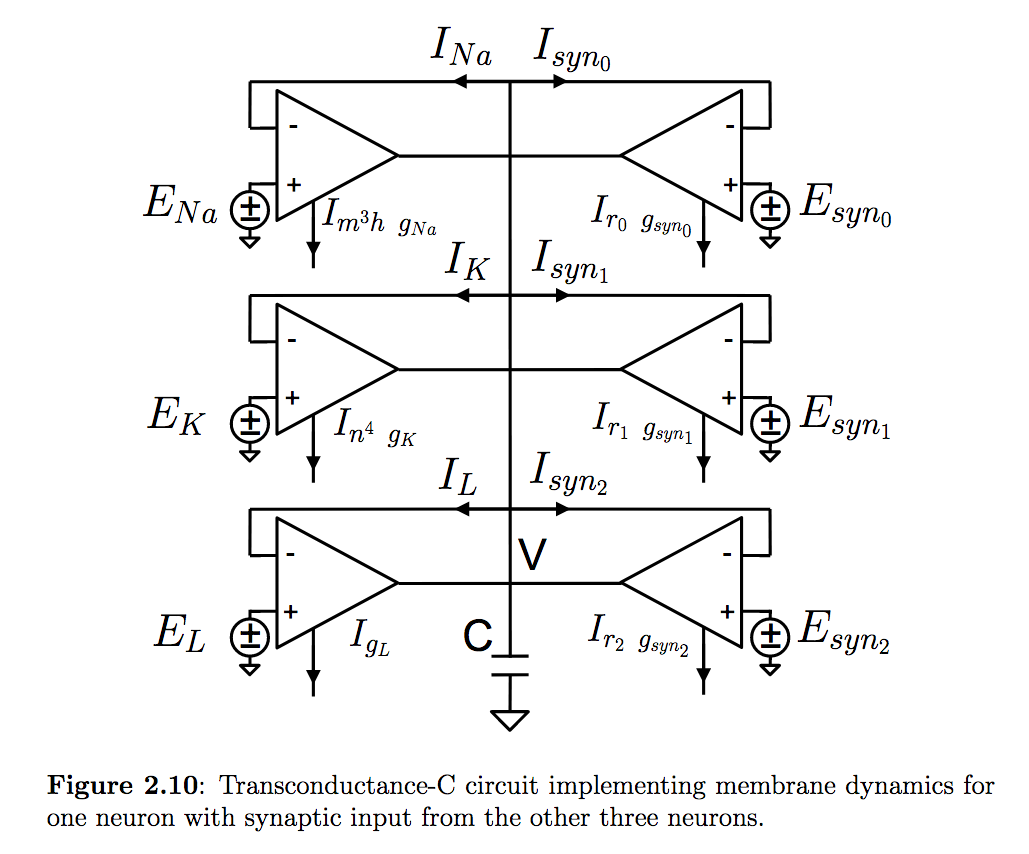

# OneNote Calculations

## OTA Current

$
I_{ext} 
= C \frac{\displaystyle dV}{\displaystyle dt}
+ g_L (V_{mem} - E_L)
$

$
g_L 
= \frac{\displaystyle κ I_{g_L}}{\displaystyle V_{th} }
\frac{\displaystyle 1}{\displaystyle M}
\frac{\displaystyle DAC}{\displaystyle 1024} 
$

$
g_{L, ideal} 
= \frac{\displaystyle I_{master}}{\displaystyle M}
\frac{\displaystyle DAC}{\displaystyle 1024} 
$

In [ ]:
Ivoltage = 3e-6 # 3uA
mirror_ratio = 10
EL_DAC = 400
R = 1.632e6 # need to measure
Vref = 0.9

In [ ]:
EL = Ivoltage/mirror_ratio * (EL_DAC / 1024) * R + Vref

In [ ]:
# Programmed
#gL_DAC = [100, 500, 1024] # 200?
gL_DAC = 200
Imaster = 20e-9 # is this Imaster_gmax?

# Measured
Iext = [100e-12, 200e-12, 400e-12]
Vpp = [228.58e-3, 0.09, 0.0925] # mean of Vpp

kappa = 0.7
Vth = 26e-3

# Calculated comparisons
for i in range(len(Iext)):
    gL_meas = (1 / (kappa/Vth)) * 2 * Iext[i] / Vpp[i] #(EL - Vmem_ss[i])
    gL_calc = (Imaster/mirror_ratio) * (gL_DAC/1024)
    print('gL (Iext={:.0f}pA) = {:.2f} nA vs. {:.2f}'.format(
        Iext[i]/1e-12, gL_meas/1e-9, gL_calc/1e-9)
    )

In [ ]:
gL_meas / 1e-9

## Using time constants

$
\tau = \frac{\displaystyle C_{mem}}{\displaystyle g_L}
$


In [ ]:
Cmem = 6e-12
tau = [60e-3, 30e-3, 15e-3]
for t in tau:
  gL = Cmem / (t /2.2) # 2.2 to go from rise time to time constant (e)
  print(gL/1e-9)

# Setup neurodyn for characterization testing
Check the mux / probe settings

### Connect Notebook to Opal Kelly

In [1]:
import platform

import os
import sys
if platform.system() == 'Darwin':
    sys.path.append("okFiles/Mac//")
elif platform.system() == 'Windows':
    sys.path.append("okFiles/Win//")
else:
    print(f'We might need Opal Kelley drivers for {platform.system()}')

# initialize neurocube device (dev)
from nc import SsRx, dev

Device Count:	 1
Device Open:	 True
Device Info:
Opal Kelly XEM6310
XEM6310-LX150


In [ ]:
dev = SsRx() # force a new connection (as importing a module would only work once in a jupyter session)

# helper functions
from NeuroCube_functions_g import *

import time
import pyvisa

from numpy import sign as sign

### Connect notebook to Siglent Scope
Programming manual is here:
https://siglentna.com/wp-content/uploads/dlm_uploads/2017/10/ProgrammingGuide_forSDS-1-1.pdf

In [ ]:
import pyvisa

# Select a VISA backend if needed
rm = pyvisa.ResourceManager()
#rm = pyvisa.ResourceManager('@py')

# List all availabke connections
for resource in rm.list_resources():
    print(resource)

# Connect to MSO6034A
INSTR_ADDR = 'USB0::0xF4EC::0xEE38::SDSMMFCQ5R6965::INSTR' # might need to update this address

# https://siglentna.com/application-note/programming-example-sds-oscilloscope-save-a-copy-of-a-screen-image-via-python-pyvisa/

sds = rm.open_resource(INSTR_ADDR)
ID = sds.query('*IDN?')
print("Connected to", ID)

### Helper functions for scope

For screen captures:
https://siglentna.com/application-note/programming-example-sds-oscilloscope-save-a-copy-of-a-screen-image-via-python-pyvisa/

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def scope_screenshot(sds, file_name = 'SCDP.bmp'):
    
    sds.write("SCDP")
    result_str = sds.read_raw()
    f = open(file_name,'wb')
    f.write(result_str)
    f.flush()
    f.close()

    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    plt.show()
    
scope_screenshot(sds)

In [ ]:
def scope_meas(sds, channel = 'C2'):
    
    Vmin_V = sds.query(f'{channel}:PAVA? MIN').split(',')[-1]
    try:
        Vmin_V = float(Vmin_V.split(',')[-1].strip('V\n'))
    except ValueError as e:
        print(e)
        Vmin_V = 0
        
    Vmax_V = sds.query(f'{channel}:PAVA? MAX')
    Vmax_V = float(Vmax_V.split(',')[-1].strip('V\n'))

    Trise_s = sds.query(f'{channel}:PAVA? RISE')
    Trise_s = float(Trise_s.split(',')[-1].strip('S\n'))

    print(f' Min[{channel}]\t= {Vmin_V}V')
    print(f' Max[{channel}]\t= {Vmax_V}V')
    print('Rise[{}]\t= {:.2f}us'.format(channel, Trise_s * 1e6))
    
    return Vmax_V, Vmin_V, Trise_s

# Try running
scope_meas(sds)

### Helper functions for writing to gap junctions / neurons

In [4]:
def write_Gap_Junction_rows(dev, rows_to_update = [0x01, 0x02, 0x03, 0x04]):
    for row in rows_to_update:
        
        # Set ports of gap junction for a row ###################################
        write_Gap_Junction(dev, row, 0x0401)           # disable shutdown mode, disable transition detection

        write_Gap_Junction(dev, row, 0x0955)           # configuration -- set P7, P6, P5, P4 as output ports
        write_Gap_Junction(dev, row, 0x0A55)           # configuration -- set P11, P10, P9, P8 as output ports
        write_Gap_Junction(dev, row, 0x4400)           # ports 4-11 output logic 0 


        write_Gap_Junction(dev, row, 0x0B55)           # configuration -- set P15, P14, P13, P12 as output ports
        write_Gap_Junction(dev, row, 0x0C55)           # configuration -- set P19, P18, P17, P16 as output ports
        write_Gap_Junction(dev, row, 0x4C00)           # ports 12-19 output logic 0 


        write_Gap_Junction(dev, row, 0x0D55)           # configuration -- set P23, P22, P21, P20 as output ports
        write_Gap_Junction(dev, row, 0x0E55)           # configuration -- set P27, P26, P25, P24 as output ports
        write_Gap_Junction(dev, row, 0x5400)           # ports 20-27 output logic 0 


        write_Gap_Junction(dev, row, 0x0F55)           # configuration -- set P31, P30, P29, P28 as output ports
        write_Gap_Junction(dev, row, 0x5C01)           # port 28 (neurodyn 1 dac's CSbar) outputs logic 1, ports 29-31 output logic 0
        
def update_neuron(
    dev,
    # NeuroDyn chip within NeuroCube
    neurodyn_sel = 0,
    neuron = 3, # only neuron 3 spikes with current params, although all neurons show activity during init
    gNa = 1023,
    gK = 600,
    gL = 32,
    ENa = 1023,
    EK = -1023,
    EL = 400,
    m_alpha = 128 * 2,
    m_beta = 128 * 2,
    h_alpha = 16 * 2,
    h_beta = 16 * 2,
    n_alpha = 16 * 2,
    n_beta = 16 * 2,
    gSyn = [0, 0, 0], # gsyn for all three synapses 
    
    ifSynapse = 0, 
    channelNum = 0, 
    typ = 0,                     # select alpha/beta rate, maximal conductance, reversal potential 
    bumpNum = 0                  # a2, a1, a0   --  can set addrbarxyz in dac cal mode  
):
    parms = load_matlab_data('labDemo.mat')

    # Neuron 1 -- parms['biasgErev'][0][0][0][0] -- sodium maximal conductance, parms['biasgErev'][0][0][0][1] -- sodium maximal reversal potential, parms['biasgErev'][0][0][1][0] -- potassium maximal conductance, parms['biasgErev'][0][0][1][1] -- sodium reversal potential, parms['biasgErev'][0][0][2][0] -- leak maximal conductance, parms['biasgErev'][0][0][2][1] -- leak reverse potential 
    parms['biasgErev'][neuron][0] = [[abs(gNa), abs(ENa)], 
                                     [abs(gK), abs(EK)], 
                                     [abs(gL), abs(EL)]]   
    parms['signgErev'][neuron][0] = [[sign(gNa), sign(ENa)], 
                                     [sign(gK), sign(EK)], 
                                     [sign(gL), sign(EL)]]                                                
    # sign bits for the same as described in line 274
    
    parms['biasAlphaBeta'][neuron][0][0][0][:] = [0, 0, 0, m_alpha, 0, 0, 0]          # m alpha
    parms['biasAlphaBeta'][neuron][0][0][1][:] = [0, 0, 0, m_beta, 0, 0, 0]           # m beta
    parms['biasAlphaBeta'][neuron][0][1][0][:] = [0, 0, 0, h_alpha, 0, 0, 0]          # h alpha
    parms['biasAlphaBeta'][neuron][0][1][1][:] = [0, 0, 0, h_beta, 0, 0, 0]           # h beta
    parms['biasAlphaBeta'][neuron][0][2][0][:] = [0, 0, 0, n_alpha, 0, 0, 0]          # n alpha
    parms['biasAlphaBeta'][neuron][0][2][1][:] = [0, 0, 0, n_beta, 0, 0, 0]           # n beta

    parms['signAlphaBeta'][neuron][0] = [[1, -1], [-1, 1], [1, -1]]                  # Neuron 1
    
    # Synapse parameters
    parms['biasgErev'][neuron][1] = [[gSyn[0], 256], [gSyn[1], 256], [gSyn[2], 256]]
    parms['signgErev'][neuron][1] = [[1, 1], [1, -1], [1, 1]]  # sign = -1 for Erev for an INHIBITORY synapse on neuron 1 (Vpost) from neuron 3 (Vpre)
    
    parms['biasAlphaBeta'][neuron][1] = [[[  0,   0,   0,   20,   0, 0, 0],
                                     [  200,   10,  5,   0,   0,   0,   0]],

                                    [[  0,   0,   0,   20,   0,  0, 0],
                                     [  200,   10,   5,   0,   0,   0,   0]],

                                    [[  0,   10,   20,   40,   80,  120, 240],
                                     [  1000,   1000,   1000,   0,   0,   0,   0]]]

    parms['signAlphaBeta'][neuron][1] = [[1, -1], [1, -1], [1, -1]]

    # for soma
    load_int_dacs(dev, parms['signAlphaBeta'],
                  parms['signgErev'],
                  parms['biasAlphaBeta'],
                  parms['biasgErev'],
                  neuron,
                  0, neurodyn_sel)

    # for synapses
    load_int_dacs(dev, parms['signAlphaBeta'],
                  parms['signgErev'],
                  parms['biasAlphaBeta'],
                  parms['biasgErev'],
                  neuron,
                  1, neurodyn_sel)

    addr = (neuron << 8) + (ifSynapse << 7) + (channelNum << 5) + (typ << 3) + bumpNum # neuron 0, channel = 0 (m); m, h, n = [0,32,64]
    set_internal_dacs_address(dev, addr, neurodyn_sel)
    

# Neurodyn main code   

In [5]:
write_Gap_Junction_rows(dev, [0x01, 0x02, 0x03, 0x04])

AttributeError: 'NoneType' object has no attribute 'SetWireInValue'

In [6]:
dev

In [ ]:
neurodyn_sel = 0     # choose from: 0, 1, 2, 3
neuron = 2           # choose from: 0, 1, 2, 3

In [ ]:
write_external_DACs_neurodyn(dev, Vref_neurodyn, 1.2, neurodyn_sel+1)       # 0.9v      
write_external_DACs_neurodyn(dev, vBiasN, 1.365, neurodyn_sel+1)            # 1.4v        
write_external_DACs_neurodyn(dev, vBiasP, 1.694, neurodyn_sel+1)            # 1.7v        
write_external_DACs_neurodyn(dev, Vb, 0.9012, neurodyn_sel+1)               # 0.9v         
write_external_DACs_neurodyn(dev, IinVoltagePin, 1.1, neurodyn_sel+1)       # ND1: 1.1v - 3uA       
#write_external_DACs_neurodyn(dev, IinMaster_gmax, 0.525, neurodyn_sel+1)   # ND1: 0.6211v - 40nA        
write_external_DACs_neurodyn(dev, IinMaster_gmax, 0.6211, neurodyn_sel+1)   # ND1: 0.6211v - 40nA        
write_external_DACs_neurodyn(dev, IinMasteralpha_beta, 0.58, neurodyn_sel+1)  # ND1: 0.4422v - 0.4nA       
write_external_DACs_neurodyn(dev, VmemProbeIn, 0.9, neurodyn_sel+1)         # 0.9v      

In [ ]:
chip_init(dev, neurodyn_sel)

# Set Iext for neurodyn (Howland outputs nA)
set_current_source_selector_switch_all_neurodyns(dev, 2)  # 1 - howland current source; 2 - external DAC 
set_expose_off_probe_off_all_neurodyns(dev)

# output mux is on the PCB
set_neurodyn_outputs_mux(dev, 3)   # target_output = 1 -- gTapMUX; 2 -- EreverseTapMUX; 3 -- VmemBufMUX; 4 -- VmemProbeIn       

#set_dac_cal_off_switchrpin_off(dev)

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['gL'] = []
df['EL'] = []
df['Vmin'] = []
df['Vmax'] = []
df['Trise'] = []
df

In [ ]:
# Driving 0.9V externally 

for gL in [10, 20, 50, 100, 200, 300, 400, 500, 800, 1023]:
    
    # Setup neurodyn for test
    
    set_expose_off_probe_off_all_neurodyns(dev)

    update_neuron(# NeuroDyn chip within NeuroCube
        neurodyn_sel,
        neuron = neuron, # only neuron 3 spikes with current params, although all neurons show activity during init
    )

    # Only testing the OTA for leak channel
    EL = 100
    # EL = 1023 # 24mV, Vmem = 670->896 mV with channelNum = 2, typ = 3
    # EL = 512    # 40mV, Vmem = 800->896mV with channelNum = 2, typ = 3
    # EL = 0    # 88mV, Vmem = 952->904mV mV with channelNum = 2, typ = 3

    ENa = 0  # Vmem = -> 1.16V
    #EK = 1023 # Vmem = -> 896 mV
    EK = 0 # Vmem = -> 896 mV

    # Changing these params doesn't seem to make a difference

    # zero out all the other params
    update_neuron(# NeuroDyn chip within NeuroCube
        neurodyn_sel = neurodyn_sel,
        neuron = neuron, # only neuron 3 spikes with current params, although all neurons show activity during init
        gNa = 0,
        gK = 0,
        gL = gL,
        ENa = ENa,
        EK = EK,
        EL = EL,
        m_alpha = 0,
        m_beta = 0,
        h_alpha = 0,
        h_beta = 0,
        n_alpha = 0,
        n_beta = 0,
        gSyn = [0, 0, 0], # gsyn for all three synapses 
        channelNum = 2, # channel = 0 (m); m, h, n = [0,32,64] # AU: channelNum = 2 seems to show small E changes when EreverseTapMUX is set
        typ = 3, # if typ = 2, then typ % 2 = 0 which means we are trying to access the maximal conductance. 
        # For typ = 3, typ % 2 = 1 which means we are accessing the reversal potential.
    )
    
    # Setup scope's trigger
    sds.write("C2:TRig_LeVel 950.00mv") # might need to adjust trigger level
    sds.write("ARM") # get ready for a single capture
    time.sleep(1)
    
    # Toggle probe on / off to reset Vmem
    TIME_OFF_s = 0.005
    TIME_ON_s = TIME_OFF_s / 2
    for i in range(2):
        set_probe_on_expose_off(dev, 2**neurodyn_sel)
        time.sleep(TIME_ON_s)
        set_expose_off_probe_off_all_neurodyns(dev)
        time.sleep(TIME_OFF_s)
    
    time.sleep(1)
    
    print(f'gL DAC = {gL}')
    meas = scope_meas(sds)
    scope_screenshot(sds)
    
    # Add to dataframe
    row = [gL, EL]
    row.extend(meas)
    df.loc[len(df.index)] = row

In [ ]:
df[df['EL'] == 100]

In [ ]:
# https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.plot.html
df[df['EL'] == 100].plot(
    x = 'gL',
    y = 'Trise',
    logy = True,
    logx = True,
    kind = 'scatter',
)

In [ ]:
dev.xem.Close()
# Must restart kernel to open the device again?

## Membrane Cap Characterisation

In [ ]:
# List all available connections
for resource in rm.list_resources():
    print(resource)

# Connect to Keithley 6430 Sub-Femtoamp Remote Sourcemeter
GPIB_ADDR='GPIB0::25::INSTR'

Ksrc = rm.open_resource(GPIB_ADDR)
ID = Ksrc.query('*IDN?')
print("Connected to", ID)

In [ ]:
# Setup neurodyn for test
write_external_DACs_neurodyn(dev, Vref_neurodyn, 1.2, neurodyn_sel+1)     # 0.9v     
set_expose_off_probe_off_all_neurodyns(dev)

neuron = 3         # choose from: 0, 1, 2, 3

update_neuron(# NeuroDyn chip within NeuroCube
    neurodyn_sel,
    neuron = neuron, # only neuron 3 spikes with current params, although all neurons show activity during init
)

# zero out all the other params
update_neuron(# NeuroDyn chip within NeuroCube
    neurodyn_sel = neurodyn_sel,
    neuron = neuron, # only neuron 3 spikes with current params, although all neurons show activity during init
    gNa = 0,
    gK = 0,
    gL = 0,
    ENa = ENa,
    EK = EK,
    EL = EL,
    m_alpha = 0,
    m_beta = 0,
    h_alpha = 0,
    h_beta = 0,
    n_alpha = 0,
    n_beta = 0,
    gSyn = [0, 0, 0], # gsyn for all three synapses 
    channelNum = 2, # channel = 0 (m); m, h, n = [0,32,64] # AU: channelNum = 2 seems to show small E changes when EreverseTapMUX is set
    typ = 3, # if typ = 2, then typ % 2 = 0 which means we are trying to access the maximal conductance. 
    # For typ = 3, typ % 2 = 1 which means we are accessing the reversal potential.
)

Ip = 100e-12
#Ioffset = 20e-12
Ioffset = 0
I = [Ip+Ioffset, -Ip+Ioffset]
T = 200e-3
I_range = Ip*10
#I_range = 1e-6

Ksrc.write('*RST') # Restore GPIB defaults (source V, measure I).
Ksrc.write(':SOUR:FUNC CURR')   
Ksrc.write(':SOUR:CURR:RANG ' + str(I_range))
Ksrc.write(':SOUR:CURR:LEV 0E-3')
Ksrc.write(':SENS:VOLT:PROT 3')
Ksrc.write(':SENS:FUNC "VOLT"')
Ksrc.write(':SENS:VOLT:RANG 5')
Ksrc.write(':OUTP ON')

# Turn probe on and start injecting current pulse
set_probe_on_expose_off(dev, neurodyn_sel+1) 

ifSynapse = 0
channelNum = 0
typ = 0                     # select alpha/beta rate, maximal conductance, reversal potential 
bumpNum = 0
addr = (neuron << 8) + (ifSynapse << 7) + (channelNum << 5) + (typ << 3) + bumpNum # neuron 0, channel = 0 (m); m, h, n = [0,32,64]
set_internal_dacs_address(dev, addr, neurodyn_sel)

try:
    while(True):
        Ksrc.write(':SOUR:CURR:LEV '+str(I[0]))
        time.sleep(T)
        #voltage_on = Ksrc.query(':MEAS?')  # Measure the voltage
        #print(voltage_on)
        Ksrc.write(':SOUR:CURR:LEV '+str(I[1]))
        time.sleep(T)
        #voltage_off = Ksrc.query(':MEAS?')  # Measure the voltage
        #print(voltage_off)
except KeyboardInterrupt:
    Ksrc.write(':SOUR:CURR:LEV 0E-9')
    print('Current injection stopped. Injected current set to 0nA.')

In [ ]:
# Stop Current Injection
Ksrc.write(':OUTP OFF')
Ksrc.write(':SOUR:CURR:LEV 0E-9')
print('Current injection stopped. Injected current set to 0nA.')

In [ ]:
# Source Voltage, Measure Current at VmemProbeIn (leakage current)

set_probe_on_expose_off(dev, 0b0001)

Ksrc.write('*RST') # Restore GPIB defaults (source V, measure I).
Ksrc.write(':SOUR:FUNC VOLT')   
Ksrc.write(':SOUR:VOLT:RANG 4')
Ksrc.write(':SOUR:VOLT:LEV 1')
Ksrc.write(':SENS:CURR:PROT 105e-6')
Ksrc.write(':SENS:FUNC "CURR"')
Ksrc.write(':SENS:CURR:RANG 100e-9')
Ksrc.write(':OUTP ON')

In [ ]:
# Source Voltage, Measure Current at VmemExtIn (Leakage current)
set_expose_off_probe_off_all_neurodyns(dev)

Ksrc.write('*RST') # Restore GPIB defaults (source V, measure I).
Ksrc.write(':SOUR:FUNC VOLT')   
Ksrc.write(':SOUR:VOLT:RANG 4')
Ksrc.write(':SOUR:VOLT:LEV 0.8')
Ksrc.write(':SENS:CURR:PROT 105e-6')
Ksrc.write(':SENS:FUNC "CURR"')
Ksrc.write(':SENS:CURR:RANG 100e-12')
Ksrc.write(':OUTP ON')

## DAC Calibration Mode

In [ ]:
def dac_cal_mode(
    dev, 
    neurodyn_sel = 0, 
    neuron = 0, 
    ifSynapse = 0, # program a neuron
    channelNum = 0,
    bumpNum = 3 # which of the seven sigmoids sends current to Iout (for measuring)
):

    set_expose_off_probe_off_all_neurodyns(dev)
    
    # addr = (neuron << 8) + (ifSynapse << 7) + (channelNum << 5) + (typ << 3) + bumpNum # neuron 0, channel = 0 (m); m, h, n = [0,32,64]
    # set_internal_dacs_address(dev, addr, neurodyn_sel)
    
    alphaSelIn = (neuron << 3) + (ifSynapse << 2) + (channelNum << 0)
    print(':05b'.format(alphaSelIn))
    
    
    update_neuron(# NeuroDyn chip within NeuroCube
        neurodyn_sel = neurodyn_sel,
        neuron = neuron, # only neuron 3 spikes with current params, although all neurons show activity during init
        gNa = 0,
        gK = 0,
        gL = 0,
        ENa = 0,
        EK = 0,
        EL = 0,
        m_alpha = 1024,
        m_beta = 1024,
        h_alpha = 1024,
        h_beta = 1024,
        n_alpha = 1024,
        n_beta = 1024,
        gSyn = [0, 0, 0], 
        ifSynapse = ifSynapse, 
        channelNum = channelNum, # m, n, h 
        typ = 0,                      # select alpha/beta rate, maximal conductance, reversal potential 
        bumpNum = bumpNum,             # a2, a1, a0   --  can set addrbarxyz in dac cal mode  
    )
    
    # sets Vbias (right side of diff pair)
    set_dac_cal_on_switchrpin_off(dev)
    
    # sets Vmem (left arm) to external DAC
    set_probe_on_expose_off(dev, neurodyn_sel+1) # select switch to allow external Vmem input
    write_external_DACs_neurodyn(dev, VmemProbeIn, 0.9, neurodyn_sel+1)  # 0.9v -- ext DAC for Vmem

dac_cal_mode(
    dev, 
    neurodyn_sel = 0, 
    neuron = 0, 
    ifSynapse = 0, # program a neuron
    channelNum = 0,
    bumpNum = 3 # which of the seven sigmoids sends current to Iout (for measuring)
)